#  <center> <u>Investment and Trading:</u> </center> <center>Stock Predictor</center>

# <u>Definition</u>

### Project Overview

The stock market is a collection of buyers and sellers of fractions of company ownership. Buyers and sellers can take a variety of forms from individuals to investment firms to funds. Their goal is to understand how to make more profitable decisions with their investments. Copious data is available in the form of historical prices. These prices will be used to generate training data for machine learning algorithms.

The endeavor of this project will be to provide return predictions for investments over a user defined period from the present day.

Data used in this project is retrieved from the Yahoo Finance API provided through the `pandas` library. Historical data including the information of concern, adjusted closing prices, are retrieved using a company symbol, an all uppercase group of characters representing how the company is referred to in the market ("AAPL" for Apple). The historical adjusted closing prices are requested for all trading days in the past year up to the day the program is run as specified in the project `README.md` file.

### Problem Statement

Accurate predictions of future stock returns provide the opportunity to make profitable and responsible investments. Stock price movements, increases and decreases in stock value, are known to be difficult to predict. Stock prices are subject to a lot of context created by participants in the stock market. While saturated with noise, there is still information that can be exploited to make more responsible market strategies.

### Metrics

The metrics used to measure the performance of the models will be Root Mean Squared Error (RMSE), Mean Average Percentage Error (MAPE), and Correlation. 

RMSE makes sense to use in most contexts because it gives a scale of the regression error in the same units as the prediction itself. MAPE, on the other hand, makes sense to use when the outcome in question is the future stock price and not the return. MAPE gives an estimate of the error as a percentage of the overall price of a stock. Since the outcome this project will focus on is investment return (future price / present price - 1) which is normally on a scale from -1 to +1, this project will display RMSE for aesthetic purposes. In other words, RMSE displays a less intimidating view of the error.

Correlation is also displayed to show how well the predictions trend with the true value of the returns.

# <u>Analysis</u>

### Data Exploration

The complex nature of presenting this data is that trends in the stock market are constantly changing. In this project, a variety of Company symbols will be used to display how the analysis was conducted. The figure below is an example of how random the market returns seem.

In [11]:
from dataset_construction import create_input, create_output
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [12]:
ibm = create_input("IBM")
ibm_future_prices = create_output("IBM", use_prices=True)
ibm_future_returns = create_output("IBM", use_prices=False)
ibm_future_prices.columns = ["Future_IBM"]
ibm_future_returns.columns = ["Returns_IBM"]

print ibm.join(ibm_future_prices).join(ibm_future_returns).iloc[:6]

            AdjClose_IBM  Future_IBM  Returns_IBM
Date                                             
2015-06-08    159.275180  160.161432     0.005564
2015-06-09    159.602705  160.720159     0.007001
2015-06-10    162.723864  161.038056    -0.010360
2015-06-11    162.589000  162.078442    -0.003140
2015-06-12    160.864666  160.864666     0.000000
2015-06-15    160.161432  161.577512     0.008842


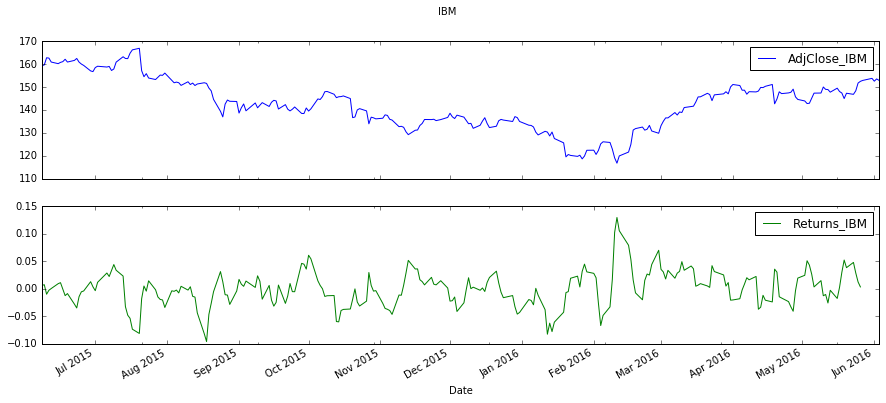

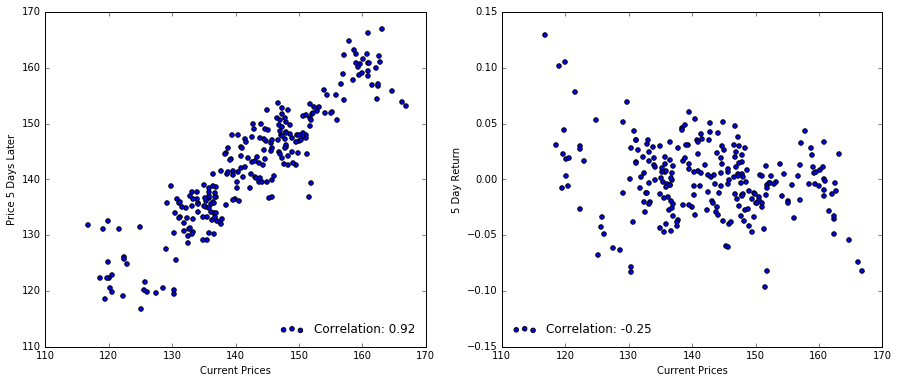

In [13]:
ibm.join(ibm_future_returns).plot(subplots=True,figsize=(15,6), title="IBM")

prices_corr = ibm.join(ibm_future_prices).corr()["AdjClose_IBM"]["Future_IBM"]
returns_corr = ibm.join(ibm_future_returns).corr()["AdjClose_IBM"]["Returns_IBM"]

f, axarr = plt.subplots(1,2, figsize=(15,6))
axarr[0].scatter(ibm,ibm_future_prices, label="Correlation: {}".format(round(prices_corr,2)))
axarr[0].set_xlabel('Current Prices')
axarr[0].set_ylabel('Price 5 Days Later')
axarr[0].legend(loc="lower right", frameon=False)
axarr[1].scatter(ibm,ibm_future_returns, label="Correlation: {}".format(round(returns_corr,2)))
axarr[1].set_xlabel('Current Prices')
axarr[1].set_ylabel('5 Day Return')
axarr[1].legend(loc="lower left", frameon=False)

plt.show()

When prices are low, prices 5 days later are likely to remain low by comparison. On the other hand, there is a moderate negative correlation between current price and 5 day returns. This implies that when prices are low, a positive return would be expected, while when prices are high, a negative return is somewhate more likely.

### Exploratory Visualization

### Algorithms and Techniques

### Benchmark

There are a few benchmarks that this project will endeavor to beat. The first is to achieve a better test error than 

# <u>Methodology</u>

### Data Preprocessing

With regard to abnormalities in the data, there were not many. Occasionally, there will be gaps in Adjusted Closing data from one date to another. It is common practice to simply feed the last observed price forward to a date where there is data. That is one of the many functionalities of the Pandas library in python, specifically `DataFrame.bfill()` and `DataFrame.ffill()`.

Other than the `NaN` values discussed above, there were some that were produced by the indicators developed in this project along with in the construction of the output data. Some indicators were constructed from a defined number of trading days into the past. This meant that for some days not all the information was available to create the indicator and `NaN` values were produced. These rows were simply eliminated using `DataFrame.dropna()`.

In [19]:
# Creates input data with a 4 day window bollinger value indicator
from indicators.Bollinger import Bollinger
df = create_input("IBM", indicators=[Bollinger(4)])
print df.iloc[:6]
print
print df.iloc[:6].dropna()

            AdjClose_IBM  Bollinger_AdjClose_IBM
Date                                            
2015-06-08    159.275180                     NaN
2015-06-09    159.602705                     NaN
2015-06-10    162.723864                     NaN
2015-06-11    162.589000                0.413611
2015-06-12    160.864666               -0.194547
2015-06-15    160.161432               -0.559678

            AdjClose_IBM  Bollinger_AdjClose_IBM
Date                                            
2015-06-11    162.589000                0.413611
2015-06-12    160.864666               -0.194547
2015-06-15    160.161432               -0.559678


In [20]:
# Creates output data of 3 day future returns
df_output = create_output("IBM",horizon=3)
print df_output.iloc[-7:]
print
print df_output.iloc[-7:].dropna()

               y_IBM
Date                
2016-05-25  0.013514
2016-05-26  0.000459
2016-05-27  0.004318
2016-05-31 -0.005529
2016-06-01       NaN
2016-06-02       NaN
2016-06-03       NaN

               y_IBM
Date                
2016-05-25  0.013514
2016-05-26  0.000459
2016-05-27  0.004318
2016-05-31 -0.005529


### Implementation

### Refinement

# <u>Results</u>

### Model Evaluation and Validation

In [16]:
from predict_future import predict_spy_future
print predict_spy_future(horizon=5)

           ReturnDate Symbol    Return  TestError(RMSE)  Benchmark_0(RMSE)  \
Date                                                                         
2016-06-03 2016-06-10    AAL  0.087899         0.092655           0.037808   
2016-06-03 2016-06-10    UAL  0.077032         0.079444           0.027191   
2016-06-03 2016-06-10    CHK  0.053804         0.161552           0.169142   
2016-06-03 2016-06-10    SIG  0.042865         0.066360           0.055639   
2016-06-03 2016-06-10     GT  0.040931         0.052109           0.040028   
2016-06-03 2016-06-10    DAL  0.038125         0.036257           0.022641   
2016-06-03 2016-06-10    NKE  0.036015         0.034613           0.019621   
2016-06-03 2016-06-10   NFLX  0.035317         0.049528           0.058783   
2016-06-03 2016-06-10    VLO  0.033458         0.057018           0.039280   
2016-06-03 2016-06-10     KR  0.031311         0.023382           0.022434   

            TestCorrelation  
Date                         
201

### Justification

# <u>Conclusion</u>

### Free Form Visualization

### Reflection

### Improvement

There are a myriad of improvements that can be made to this product. There are hundreds, if not thousands, of indicators used in inter and intraday trading. There is continuous analysis and debate over which indicators are most effective, just as there is the same analysis and debate over which models are most effective in this realm.